In [ ]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

# Linear and Logistic Regression
<!-- requirement: images/linear_regression_error.gif -->
<!-- requirement: images/ridge_lasso.png -->
<!-- requirement: small_data/mnist.pkl -->

*&copy; The Data Incubator*

You should be familiar with linear regression.  Let's talk about it mathematically.

## Predictive modeling framework

Recall that for this and all other machine-learning setups, $X = \{X_{ij}\}$ is an $n \times p$ matrix of features and $y_i$ is an $n$-vector of labels.  In all **supervised** learning problems, we are trying to build a **model** $f$ (predictive relationship) mapping the feature rows $X_{j \cdot}$ to each label $y_j$ so that

$$f(X_{j \cdot}) \approx y_j\,.$$

All supervised learning can be represented in this form.  The parameters that can change are:

1. The **model** $f$.  This module will only cover linear models.  We will often assume that one of the columns of $X$ is the constant $1$.  Therefore,

 $$ f(X_{j \cdot}) = X_{ji} \cdot \beta_i$$

 represents the entire linear model concisely, including the constant intercept term.

1. The **error distribution** of how $y_j$ are distributed.  If the model $f$ is linear, varying the error distribution gives us different classes of the General Linear Models (GLM)s.  We'll talk about the Logistic Regression (arguably the most important GLM after linear regression) but there are many others.  To learn more about GLMs, there are a good set of notes available [here](http://data.princeton.edu/wws509/notes/a2.pdf).

With both a model and the error distribution, we can easily compute find the likelihood function.  The problem in GLM is to choose the model that maximizes the likelihood function.

## Linear Regression

Remember the basic picture of linear regression errors:

![$L^1$ versus $L^2$ regularization](images/linear_regression_error.gif)

Linear Regression is perhaps the simplest linear model $f(X_{j \cdot}) = \sum_i \beta_i X_{ji}$.  The error model assumes the $y_j$'s are independent and normally distributed around $X_{ji} \cdot \beta_i$ with standard deviation $\sigma$.  

### Likelihood and cost functions
Suppose that we knew that the correct model was given by some $\beta_i$.  Given the above assumption about the error model, the probability of measuring $y_j$ is simply

$$ P(y_j \mid \beta_i) = \prod_j \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left[-\left( \frac{X_{ji} \cdot \beta_i - y_j}{2 \sigma} \right)^2 \right] \,.$$

However, we don't know the $\beta_i$.  Instead we want to find them, given the $y_j$, by finding the $\beta_i$ that maximize $P(\beta_i \mid y_j)$.  Thanks to Bayes' Rule, we know

$$ P(\beta_i \mid y_j) = P(y_j \mid \beta_i) \frac{P(\beta_i)}{P(y_j)} \,.$$

We know the first term on the RHS, and $P(y_j)$ is independent of $\beta_i$, leaving only $P(\beta_i)$ unknown.  In linear regression, we suppose we have no *a priori* knowledge of the expected coeffiecients and take $P(\beta_i)$ to be constant as well.  Thus, the most probable model is determined by maximizing the likelihood function

$$ L(\beta) = \prod_j \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left[-\left( \frac{X_{ji} \cdot \beta_i - y_j}{2 \sigma} \right)^2 \right] \propto P(\beta_i \mid y_j) \,.$$

Since $\log$ is monotonic, we can also maximize the log-likelihood.  A few calculations show us that the negative log-likelihood (up to a linear transformation) is

$$- \log(L(\beta)) \sim \| y - X \beta \|^2\,.$$

Here, $\| z \| = \| z \|_2 = \sum_i |z_i|^2 $ is the $L^2$ norm.  The objective is to minimize this quadratic:

$$ \min_\beta \| y - X \beta \|^2\,.$$

Of course, this is the familiar expression for linear regression.  We could minimize $\beta$ via gradient descent, but it turns out that the solution has a closed form, 

$$ X \hat \beta = y\,, $$

or

$$ \hat \beta = (X^T X)^{-1} X^T y\,. $$

** Questions: ** 

1. What about the intercept term?
1. Prove that the solution $\hat \beta$ actually minimizes the negative log-likelihood.  (Hint: $X (X^T X)^{-1}X^T$ is the projection operator onto the subsapce spanned by the columns of $X$).
1. What happens if $X^T X$ is singular, e.g. $X$ has two columns that are co-linear.  What does this mean in terms of identification?  When might this occur in the data in real life?
1. What happens when $p \gg n$?  How do you deal with this?
1. What is the effect of outliers?  How do you deal with them?
1. What if $y$ values are always positive?  What if $y$ values are in a fixed range $[a,b]$?

### Using Linear Regression

In [1]:
from sklearn import datasets, linear_model, utils, preprocessing
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import dill

with open("small_data/mnist.pkl", "r") as fin:
    mnist = dill.load(fin)

# This dataset gives house prices in Boston based on a variety of factors.
# for more information about what the fields mean, checkout http://mldata.org/repository/data/viewslug/regression-datasets-housing/
original_columns = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSAT"]

np.random.seed(42)
Xraw, y = utils.shuffle(mnist.data, mnist.target)
Xraw = pd.DataFrame(Xraw, columns=original_columns)
y = pd.Series(y)

For illustration, we'll start by fitting a single feature.

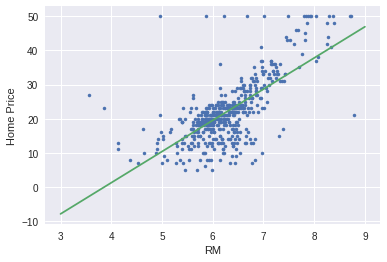

In [3]:
%matplotlib inline
X1 = Xraw[['RM']]
linreg = linear_model.LinearRegression(fit_intercept=True)  # This is the default
linreg.fit(X1, y)
plt.plot(X1, y, '.')
x = np.linspace(3, 9).reshape(-1,1)
plt.plot(x, linreg.predict(x), '-')
plt.xlabel('RM')
plt.ylabel('Home Price')

Now, let's look at all of the features.

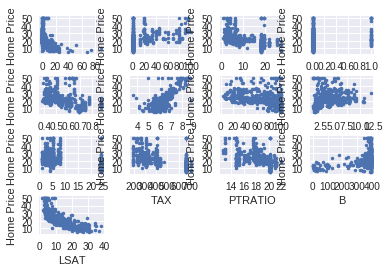

In [4]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i, col in enumerate(Xraw):
    plt.subplot(4, 4, i+1)
    plt.plot(Xraw[col], y, '.')
    plt.locator_params(nbins=6)
    plt.xlabel(col)
    plt.ylabel('Home Price')

Some of these features look to be linear, but others aren't.  Somtimes, the inverse of features with negative correlation produces a better fit.  Relationships that look like step functions are better modeled with indicator features.

In [6]:
X = Xraw.copy()
X["INV_CRIM"] = 1./X.CRIM
X["INDUS7"] = X.INDUS <= 7.
X["INDUS16"] = 1. * (X.INDUS <= 16.)
X["INV_NOX"] = 1./X.NOX
X["AGE75"] = 1. * (X.AGE <= 76.)
X["RAD15"] = 1. * (X.RAD <= 15.)
X["TAX500"] = 1. * (X.TAX <= 500.)
X["PTRATIO19"] = X.PTRATIO <= 19.
X["B350"] = 1. * (X.B <= 350.)
X["INV_LSAT"] = 1. / X.LSAT
X=X.astype(float)  # coerce booleans to a float
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,INV_CRIM,INDUS7,INDUS16,INV_NOX,AGE75,RAD15,TAX500,PTRATIO19,B350,INV_LSAT
0,0.09178,0.0,4.05,0.0,0.510,6.416,84.1,2.6463,5.0,296.0,...,10.895620,1.0,1.0,1.960784,0.0,1.0,1.0,1.0,0.0,0.110619
1,0.05644,40.0,6.41,1.0,0.447,6.758,32.9,4.0776,4.0,254.0,...,17.717931,1.0,1.0,2.237136,1.0,1.0,1.0,1.0,0.0,0.283286
2,0.10574,0.0,27.74,0.0,0.609,5.983,98.8,1.8681,4.0,711.0,...,9.457159,0.0,0.0,1.642036,0.0,1.0,0.0,0.0,0.0,0.055340
3,0.09164,0.0,10.81,0.0,0.413,6.065,7.8,5.2873,4.0,305.0,...,10.912265,0.0,1.0,2.421308,1.0,1.0,1.0,0.0,0.0,0.181159
4,5.09017,0.0,18.10,0.0,0.713,6.297,91.8,2.3682,24.0,666.0,...,0.196457,0.0,0.0,1.402525,0.0,0.0,0.0,0.0,0.0,0.057904


Let's compare the performance of the model on different sets of features.

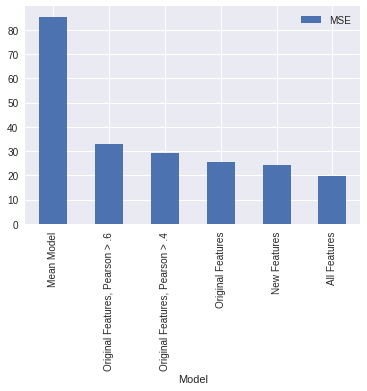

In [7]:
from sklearn import model_selection
from scipy import stats

cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(est, X, y):
    return -model_selection.cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

def abs_corr(x, y):
    return np.abs(stats.pearsonr(x, y)[0])

new_columns = ['INV_CRIM', 'ZN', 'INDUS7', 'INDUS16', 'CHAS', 'INV_NOX', 
               'RM', 'AGE75', 'DIS', 'RAD15', 'TAX500', 'PTRATIO19', 'B350', 'INV_LSAT']

model_performance = pd.DataFrame([
    ("Mean Model", y.var()),
    ("Original Features, Pearson > .6",
       compute_error(linreg, X[[col for col in original_columns if abs_corr(X[col], y) > .6]], y)),
    ("Original Features, Pearson > .4",
       compute_error(linreg, X[[col for col in original_columns if abs_corr(X[col], y) > .4]], y)),
    ("Original Features", compute_error(linreg, X[original_columns], y)),
    ("New Features", compute_error(linreg, X[new_columns], y)),
    ("All Features", compute_error(linreg, X, y)),
], columns=["Model", "MSE"])
model_performance.set_index("Model")
model_performance.plot(x="Model", y="MSE", kind="Bar")

In [8]:
[col for col in original_columns if abs_corr(X[col], y) > .6]

['RM', 'LSAT']

### A few notes:

1. A good baseline is to see how well a mean model performs, that is, take a model that predicts `y.mean()` and whose MSE is going to be `y.var()`.
1. How many (original) features have a correlation coefficient > .6?  These explain the majority of the error (compared with the baseline model).
1. One way to prevent this overfitting is to choose only those feautes $X_{\cdot i}$ that are highly correlated with $y$.  This can lead much better models.

**Question:** 
1. We tried to predict $y$ but since it is non-negative, it might make sense to predict $\log(y)$.  What metric would you use to be able to evaluate which one is better?


## Regularization
### Ridge Regression

In the problem above, we used an *ad-hoc* criteria to select features.  Essentially, this reflects an expectation that most coefficients should be zero.  A more principled approach is to choose a prior distribution for $P(\beta_i)$ that is peaked about $\beta_i = 0$, instead of uniform.  We'll start by taking the coefficients to be identical independently normally distributed about 0 with a standard deviation of $\sigma/\sqrt\alpha$, where $\alpha$ is a hyperparameter:

$$ P (\beta_i) \propto \prod_i \exp \left[ -\frac{\alpha}{2} \left(\frac{\beta_i}{\sigma} \right)^2\right] \,,$$

so

$$ L(\beta) \propto \prod_j \exp\left[ -\frac{1}{2}\left( \frac{X_{ji} \cdot \beta_i - y_j}{\sigma} \right)^2 \right]\prod_i \exp \left[ -\frac{\alpha}{2} \left(\frac{\beta_i}{\sigma} \right)^2\right] \,.$$

Then the negative log-likelihood is (up to a linear transformation)

$$- \log(L(\beta)) \sim \| y - X \beta \|^2 + \alpha \| \beta \|^2\,.$$

After compleing the square, it turns out that the solution has a closed form, 

$$ \hat \beta = (X^T X + \alpha I)^{-1} X^T y\,. $$

To get some motivation for what's happening, use the *singular value decomposition*

$$ X = U \Sigma V^T $$

We  can see that 

$$ \hat \beta = V D U^T y $$

where

$$ D_{ii} = \frac{\Sigma_{ii} }{\Sigma_{ii}^2 + \alpha}\,. $$

When $\alpha = 0$, $D_{ii} = \frac{1}{\Sigma_{ii}}$ and it decreases to 0 as $\alpha \to \infty$.  The smaller $\Sigma_{ii}$, the faster this decrease to 0 (for a given level of $\alpha$).  So smaller $\Sigma_{ii}$ are "shrunk" faster than larger $\Sigma_{ii}$ and we get the "significant values" are left.

**Questions:**
1. Are "significant values" always left?  What pre-processing step might one do to ensure this?
1. Can you prove the formula for $\hat \beta$ for Ridge Regression from ordinary Linear Regression?
1. What is the corresponding prior for plain-vanilla linear regression?
1. Compared with linear regression, how to you expect the $\beta$'s to behave?  How does this behavior change as you vary $\alpha$?

This technique is called many things including **Shrinkage**, **$L^2$-regularization**, ** Tikhonov-Regularization**, **Ridge-regression**.  We can use cross-validation to choose an optimal value of $\alpha$.  The answer is still quadratic in $\beta$ so we can compute the answer in closed form.

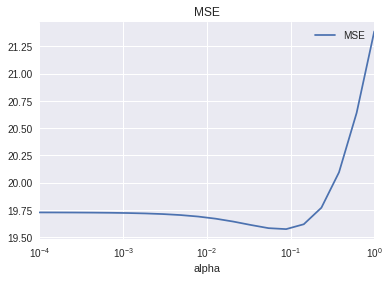

In [9]:
# Ridge regression using cross validation linear_model.Ridge
import numpy as np
np.random.seed(42)

alphas = np.logspace(-4., 0, 20)
ridge_models = pd.DataFrame(
    [(alpha,
      "Ridge Regression with alpha = %f" % alpha, 
      compute_error(linear_model.Ridge(alpha=alpha), X, y)) for alpha in alphas],
    columns=['alpha', 'Model', 'MSE'])
ridge_models.plot(x='alpha', y='MSE', logx=True, title='MSE')

In [ ]:
coefs = np.array([linear_model.Ridge(alpha=alpha).fit(X, y).coef_
                  for alpha in alphas])
plt.semilogx(alphas, coefs)
plt.xlabel('alpha')
plt.ylabel('Coefficients')

### Lasso Regression

Lasso is like ridge regression but has the ability to automatically select features.  The objective function to minimize is

$$ \frac{1}{2 n} \| y - X^T \beta \|^2 + \alpha \|\beta\|_1 $$

where $\|\beta\|_1 = \sum_i |\beta_i| $ is the $L^1$ norm (sum of the absolute values) of $\beta$ and $n$ is the number of samples.  This is called **Lasso Regression** or **$L^1$-Regularization** because it is basically Ridge Regression where the extra prior term is an $L^1$ penalty instead of an $L^2$ penalty.  Lasso has a feature selection property where many weights on features are zero (i.e. those features are not selected).

We can see this behavior by contrasting the effects of regularization on a single parameter.  Because the $L^2$ regularization has slope 0 at $\beta=0$, the minimal value of $\beta$ will never reach 0 for finite $\alpha$.  This is not the case for lasso regression, where a finite $\alpha$ can make the optimal $\beta$ go all the way to zero, excluding that feature from consideration.

In [ ]:
beta = np.linspace(-1,2,100)
base_error = (beta - 1)**2 - 1

for pow in [2,1]:
    plt.subplot(123 - pow)
    for a in xrange(0, 5):
        plt.plot(beta, base_error + a * abs(beta)**pow, label=r'$\alpha = %i$' % a)
    plt.ylim(-2, 4)
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$-\log(L(\beta))$')
    plt.legend(loc=3)
    plt.title({2: 'Ridge Regression', 1: 'Lasso Regression'}[pow])

In [ ]:
# Lasso Regression with cross validation
np.random.seed(42)
alphas = np.logspace(-5., -1., 20)

lasso_models = pd.DataFrame(
    [(alpha,
      "Lasso with alpha = %f" % alpha,
      compute_error(linear_model.LassoLars(alpha=alpha), X, y)) for alpha in alphas],
    columns=['alpha', 'Model', 'MSE'])
lasso_models.plot(x='alpha', y='MSE', logx=True, title='MSE')

In [ ]:
coefs = np.array([linear_model.LassoLars(alpha=alpha).fit(X, y).coef_
                  for alpha in alphas])
plt.semilogx(alphas, coefs)
plt.xlabel('alpha')
plt.ylabel('Coefficients')

We can also build our intuition of Ridge and Lasso regression by considering the figure below. Consider two features whose weights $\beta_1$ and $\beta_2$ are represented by the $x$ and $y$ axes, respectively. The error function is shown in grey and its minimum is located at the center of the ellipses, at $\vec{\beta} = \hat{\beta}$. However, given the red constraint regions, $\beta_1^2 + \beta_2^2 \leq \alpha^2$ (left) and $|\beta_1| + |\beta_2| \leq \alpha$ (right), the minima of error functions now lie on the edges of the constraint regions. Since the $L^1$ constraint forms a diamond, new values for $\hat{\beta}$ will tend to fall on the corners where 1 component (or more than one component) of $\beta$ zero. For this reason Lasso regresson "throws out" features while Ridge regresson decreases the weights or contributions of features without making them zero.
![$L1$ versus $L2$ regularization](images/ridge_lasso.png)

### Elastic Net

You can combine both $L^1$ and $L^2$ regularization in something called Elastic Net.

### Cross-validation and warm starts

There's no closed-form solution for either Lasso or Elastic net so they required a numerical solution, e.g. gradient descent.  Take a look at the functions `linear_model.lasso_path` and `linear_model.enet_path`, which use a warm start technique to speed up the cross-validation.  Also note that there is `linear_model.RidgeCV`, `linear_model.LassoCV`, which return the best estimators using warm-starts.  Note that the default cross-validation is the slow leave-one-out algorithm so you'll probably want to tell it to use something like KFold cross-validation:
``` python
linear_model.RidgeCV(
    alphas=np.logspace(-1, 1, 5),
    cv=cross_validation.KFold(5))
```

**Questions:** 

1. In $L^2$ regularization, the prior on $\beta$ are i.i.d normal distributions centered around 0.  What is the analogous prior for $L^1$ regularization?

**Exercises**: 
* Use `lasso_path` to rewrite the inefficient cross validation done below and reproduce the same plot.  Does it run faster?
* Normalize the feature matrix before fitting with $L^1$ and $L^2$-regularized regressions.  Examine the coefficients of the fit.  Does the normalization change which features appear to be most important?

## Combining signals with linear models

One of the great uses of linear regression (or any regression / classificaiton technique) is to combine different machine-learned signals.

For example, we can try to use non-parametric techniques on the residual error from a linear classifier.  Since the linear classifier has found all the 'linear signals', this will find some of the remaining 'non-linear signals'.

Below is an example of a model that does this.  By making this a Scikit-Learn estimator (by virtue of being a pipeline), we are able to take advantage of the existing cross-validation infrastructure.

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn import neighbors
from sklearn import ensemble
from sklearn.pipeline import Pipeline, FeatureUnion


class EnsembleTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_estimator, residual_estimators):
        self.base_estimator = base_estimator
        self.residual_estimators = residual_estimators
    
    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        y_err = y - self.base_estimator.predict(X)
        for est in self.residual_estimators:
            est.fit(X, y_err)
        return self
    
    def transform(self, X):
        all_ests = [self.base_estimator] + list(self.residual_estimators)
        return np.array([est.predict(X) for est in all_ests]).T


ensemble_pipe = Pipeline([
        ('ensemble', EnsembleTransformer(
                linear_model.LinearRegression(),
                (neighbors.KNeighborsRegressor(n_neighbors=5),
                 ensemble.RandomForestRegressor(min_samples_leaf=20)))),
        ('blend', linear_model.LinearRegression())
    ])
ensemble_pipe.fit(X, y)
    
residual_regressor_performance = pd.DataFrame([
    ("Ensemble Regressor", compute_error(ensemble_pipe, X, y))
], columns=["Model", "MSE"])
model_performance.append(residual_regressor_performance).plot(x="Model", y="MSE", kind="Bar")

**Exercises:** 

1. Add another regression technique into the mix (besides the 3 used here).  Does it improve performance?
1. The values of `n_neighbors` and `min_samples_leaf` were set at random.  Use cross validation to select the value.

## Logistic Regression

In Logistic Regression, the values of $y$ are categorical ($0$ or $1$) and assumed to be distributed binomially.  We assume that the probability $p(X_{j\cdot})$ that $y = 1$ is related to $X$ via the logit function:

$$ \mbox{logit }(p(X_{j\cdot})) = \log \frac{p(X_{j\cdot})}{1-p(X_{j\cdot})} = X_{ji} \cdot \beta_i\,. $$

Notice that the logit function $\log \frac{x}{1-x}$ is just the log odds and maps the real numbers $[0,1]$ to $\mathbb{R}$.

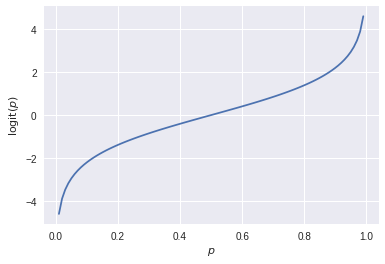

In [11]:
lx = np.linspace(0.01,0.99,98)
ly = np.log(lx/(1-lx))
plt.plot(lx,ly)
plt.xlabel('$p$')
plt.ylabel(r'$\mathrm{logit}(p)$')

It may be more clear to invert this to get an expression for $p(X_{j\cdot})$:

$$ p(X_{j\cdot}) = \frac{\exp\left( X_{ji} \cdot \beta_i\right)}{1 + \exp\left( X_{ji} \cdot \beta_i\right)} $$

The input can vary over the entire real numbers, but the output is always a valid probability between 0 and 1.

In [ ]:
lx = np.linspace(-10, 10)
ly = np.exp(lx) / (1 + np.exp(lx))
plt.plot(lx, ly)
plt.xlabel(r'$X_{ji} \cdot \beta_i$')
plt.ylabel(r'$P(X_{j\cdot})$')

The full likelihood function is given by

$$ L(\beta) = \prod_j p(X_{j\cdot})^{y_j} (1-p(X_{j\cdot}))^{1-y_j}\,. $$

Notice that the log-likelihood is just 
$$ \log(L(\beta)) = \sum_j y_j \log(p(X_{j\cdot})) + (1-y_j) \log(1-p(X_{j\cdot})) $$
Since the objective is to maxmize $L$, we can use gradient descent (on $\log(L)$) to compute the answer,

$$ \frac{\partial \log(L(\beta))}{\partial \beta} = \sum_j (y_j - p(X_{j\cdot})) X_{j\cdot} $$

The gradient is quite intuitive.  The derivation is worked out [here](http://cs229.stanford.edu/notes/cs229-notes1.pdf).

In the following example, we'll try to predict whether the home price is greater than or less than $25K.

**Questions:** 
1. What is the negative log-likelihood that is being minimized?
1. The Scikit Learn library already contains $L^1$ and $L^2$ regularization built in.  Can you write down the minimization problem with the $L^1$ and $L^2$ penalties?
1. There's a `weight` parameter to Scikit's `LogisticRegression` that lets you reweight different training examples.  When might you want to do this?

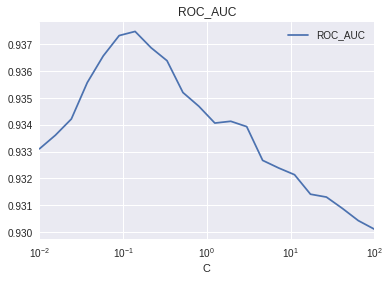

In [13]:
# Logistic Regression
# Sklearn's logistic regression comes with ROC-AUC as our objective
%matplotlib inline

np.random.seed(42)

y_cat = y > 25.
logistic_clf = linear_model.LogisticRegression()

Cs = np.logspace(-2,2,22)
lasso_models = pd.DataFrame(
    [(C,  # Inverse regularization parameter
      model_selection.cross_val_score(linear_model.LogisticRegression(C=C), 
                                       X, y_cat, cv=cv, scoring='roc_auc').mean()
    ) for C in Cs],
    columns=['C', 'ROC_AUC'])
lasso_models.plot(x='C', y='ROC_AUC', logx=True, title='ROC_AUC')

## Multiclass classification problems

So far we have talked about Two-Class classification in the context of Logistic Regression.  But what if we have more than two classes?  There are generally two strategies to "bootstrap" a binary classifier to a multi-class classifier: 
1. **One-versus-All**: For each class $k=1,\ldots,K$, build a binary classifier for all points with label $y = k$ versus $y \neq k$.
1. **All-versus-All**: For each class $k \neq k'$, construct a binary classifier to distinguish between class $k$ and $k'$.
There's also the notion of Error-Correcting Output Codes 

[Scikit](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) uses One-versus-All for Multi-class Logistic Regression.  If $f_k(x)$ is the predictor for class $k$, the probability of class $k$ is just the normalized predicitons,

$$ p_k = \frac{f_k(x)}{\sum_k f_k(x)}$$

Scikit provides a way to do other multiclass-from-binary-classifier strategies in [Scikit-Documentation](http://scikit-learn.org/stable/modules/multiclass.html).

### Minimizing $L^1$ rather than $L^2$ error in a regression.

In traditional linear regression the penalty is quadratic, which unfortuantely overpenalizes for outliers.  We often want to use absolute error instead.  There are a few ways to do this:
1. The first is to use SVM Regression `sklearn.svm.SVR`.  For `SVR`, the penalty function is the function

 $$ \max(|x| - \epsilon, 0) $$

1. The stochastic gradient descent regressor (`sklearn.linear_model.SGDRegressor`) offers the [Huber loss function](http://en.wikipedia.org/wiki/Huber_loss_function),

$$ \frac{1}{2} x^2 I_{|x| \le \delta} + \delta\left(|x| - \frac{\delta}{2}\right)  I_{|x| > \delta}$$

We plot out a comparison of these methods below:

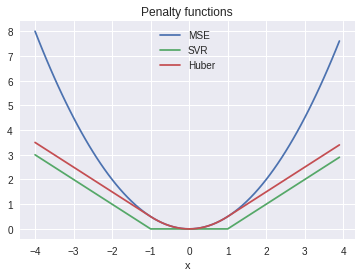

In [14]:
x = np.arange(-4,4,.1)
y_quad = x ** 2/2
y_svr = np.maximum(np.abs(x)-1.,0)
y_huber = (x ** 2/2) * (np.abs(x) <= 1) + (np.abs(x) - .5) * (np.abs(x) > 1)

plt.title("Penalty functions")
plt.xlabel("x")
plt.plot(x, y_quad, label="MSE")
plt.plot(x, y_svr, label="SVR")
plt.plot(x, y_huber, label="Huber")
plt.legend(loc='upper center')

## Stochastic Gradient Descent

Stochastic Gradient Descent is a optimization method which considers each training data individually, instead of all at once.  It uses each datum to estimate the gradient of the penalty function and then takes a step in that direction.  While each individual point will provide a poor estimation of the global minimum, combining all of these estimates results in a good global estimation.

Because it need only consider a single datum at a time, stochastic gradient descent can handle data sets too large to fit in memory.  Additionally, the training cost is essentially linear in the size of the training set.

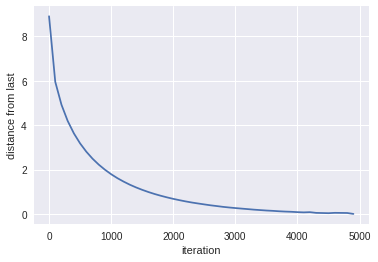

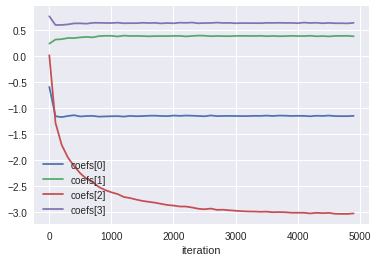

In [15]:
Xt = preprocessing.StandardScaler().fit_transform(X)

coefs = []
iterations = range(1,5000,100)
for n_iter in iterations:
    sgd_regressor = linear_model.SGDRegressor(random_state=42, n_iter=n_iter).fit(Xt, y)
    coefs.append(sgd_regressor.coef_)

    
dists = [np.linalg.norm(coef - coefs[-1]) for coef in coefs]
plt.figure()
plt.plot(iterations, dists)
plt.xlabel('iteration')
plt.ylabel('distance from last')

plt.figure()
for i in xrange(4):
    plt.plot(iterations, [c[i] for c in coefs], label='coefs[%i]' % i)
plt.legend(loc=3)
plt.xlabel('iteration')

## Quantile Regression

In a linear regression, the $L^2$ penalty in the error function means the algorithm is very sensitive to outliers. (**Question**: can you see why?)  One way to control features that have fat tails is to take a quantile transformation of them.

In [ ]:
# find the column with the highest L^2 moment compared to L^1 moment: this happens to be DIS

l2_to_l1 = np.array([np.sqrt(X[col].var()) /
                     (X[col] - X[col].mean()).abs().mean() for col in original_columns])
max_col_idx = np.argmax(l2_to_l1)

max_col_idx = 7
print pd.DataFrame([
    ("Col", X.columns[max_col_idx]),
    ("Max Ratio", l2_to_l1[max_col_idx]),
    ("Average Ratio", l2_to_l1.mean())
], columns=["Model", "MSE"])

# create a new list of column names with this column as _Quantile
new_columns = list(original_columns)
new_columns[max_col_idx] = original_columns[max_col_idx] + "_Quantile"

# sort data in this column to compute the "quantilized" value
def to_quantile(data):
    sorted_data = sorted(data)
    return np.array([1. * sorted_data.index(d)  / len(data) for d in data])
X[new_columns[max_col_idx]] = to_quantile(X[X.columns[max_col_idx]])

compute_error(linear_model.LinearRegression(), X[new_columns], y)

# Compare results
pd.DataFrame([
    ("Original Columns", compute_error(linear_model.LinearRegression(), X[original_columns], y)),
    ("With a new Quantile Column", compute_error(linear_model.LinearRegression(), X[new_columns], y))
], columns=["Model", "MSE"]).plot(x="Model", y="MSE", kind="Bar")

In [ ]:
# Let's see how close 

def compute_regression_with_quatilized_feature(max_col_idx):
    # create a new list of column names with this column as _Quantile
    new_columns = list(original_columns)
    new_columns[max_col_idx] = original_columns[max_col_idx] + "_Quantile"

    # sort data in this column to compute the "quantilized" value
    def to_quantile(data):
        sorted_data = sorted(data)
        return np.array([1. * sorted_data.index(d)  / len(data) for d in data])
    X[new_columns[max_col_idx]] = to_quantile(X[X.columns[max_col_idx]])

    return compute_error(linear_model.LinearRegression(), X[new_columns], y)

# Assemble results and plot
quantilized_models = pd.DataFrame([("Original", compute_error(linear_model.LinearRegression(), X[original_columns], y))] + 
             [(original_columns[i],
               compute_regression_with_quatilized_feature(i))
            for i in range(len(original_columns))],
columns=["Col", "Quantile"])
quantilized_models.plot(x="Col", y="Quantile", kind="Bar")

### GLM

TODO: add in the future

### Questions
1. How would you assess whether a relationship is actually linear?
1. If instead of being able to observe $y$, you observe a noisy estimate of $y \pm \epsilon$ with unbiased normally distributed noise.  What is the effect on your estimates $\beta$?
1. When you loaded your data, you unwittingly loaded each row of the data (both $X$ and $y$) twice and performed the same regression.  What is the effect on your estimates $\beta$?
1. When you loaded your data, you unwittingly loaded each column of the features (just $X$) twice and performed the same regression.  What is the effect on your estimates $\beta$?
1. Everything we've talked about so far involves loading all the data into memory.  What if you have more data than you can fit into memory?

In [ ]:
# A1. plot is. train linear model see the residual (actual y and predicted y) or 
# you can see a patterned residtual, pearson correlation may be good too but training model and plot residual would be more useful
# A3. confidence issues on your beta, good metric for confidence of beta: variance in beta when you change
# input. 
# A4. if column twice, and perorm regression. you may get overfitting
# A5. SGD. or minibatches for gredient. 

### Exit Tickets
1. Enumerate the similarities and differences between linear regression and logistic regression.
1. Explain to a layman what a likelihood function or cost function is.
1. Compare Ridge and Lasso regression (L2/L1 regularization) in terms of how they affect variance-bias.
1. What are the benefits/drawbacks to optimizing the likelihood function iteratively versus all at once?

### Spoilers

### Answers

### Linear Regression

1. Add a column of ones, or subtract off the average value of $y$.
1. The hint pretty much gives you the answer since a projection of a point onto a plane is the closest you can get to that point while still remaining on the plane. That being said, you can project the global minimum onto the accessible subspace.  Alternatively, you can differentiate the matrix expression and take the first-order condition and find the zero.
1. The matrix can't be inverted.  In practice, this shows up as numerical instabilities.  This will happen if two columns are measuring the same thing, or if one column is a linear combination of two others.
1. When $p > n$, X will be degenerate, so it can't be (psuedo-)inverted and you no longer have a unique $\beta$.  To deal with this, you can reduce the number of features with PCA or use regularization.
1. Outliers can really skew the results of $\beta$ because of the quadratic penalty.  Remember, that minimizing the least squares is essentially looking for a mean, which is affected by outliers.  You can transform the model via quantiles to reduce the effect of noise, bin the data, or use floors and caps on the data.
1. For non-negative $y$, try using the $\log(y)$.  If $y$ is always within a fixed $[a,b]$, use $$\frac{y - a}{b-a}\,.$$ Alternatively, scale by the mean / range. 

### Using Linear Regression

1. Look at coefficient of determination; plot residuals and look for a pattern.

### Ridge Regression

1. No, just the largest coefficients are left.  Scale the features beforehand, so that coefficient size gives importance.
1. The formula for $\hat \beta$ can be deduced by completing the square.  Then the problem looks exactly like an ordinary Least Squares problem with a different $X$ matrix.
1. Recall that the prior is
$$\exp \left[ -\left( \alpha \frac{\beta}{2 \sigma} \right)^2\right]$$
when $\alpha = 0$, this is a flat "improper" prior (it's not really a distribution).  This is often what a bayesian calls improper.
1. Increasing $\alpha$ shrinks the terms of $\beta$ towards zero, with smaller values of $\beta$ shrunk faster.

### Lasso Regression

1. The prior is a two-sided exponential distribution.

### Logistic Regression

1.  The negative Log-likelihood (entropy) is

    $$- \log(L(\beta)) = - \sum_j y_j \log(f(X_{j\cdot})) + y_j \log(1-f(X_{j\cdot}))$$

1.  Just add regularization terms to the log loss. The $L^2$ constraint is

    $$- \sum_j y_j \log(f(X_{j\cdot} \cdot \beta)) + y_j \log(1-f(X_{j\cdot} \cdot \beta)) + \alpha \| \beta \|^2_2$$
    
1. One answer is if one class is very common (e.g. 99% of the data), you can downsample it it and then use the weight to give an unbiased estimate.  A classic example is click-prediction in advertising, where clicks are rare compared to non-clicks.

### Module Questions

1. To assess if the relationship is linear, plot the distribution of the residuals as a function of $x$.  If there's a systematic bias, take a look at it and see what's going on.
1. With extra (unbiased) noise, the estimate of $\beta$ does not change (on average), but the the confidence goes down.
1. Loading rows twice has no effect on $\beta$ but it does artificially increase your confidence (dividing it by a factor $\sqrt{2}$)
1. The problem becomes degenerate and $\beta_j$ is now split between $\beta_{j'}$ and $\beta_{j''}$ such that $\beta_j = \beta_{j'} + \beta_{j''}$.
1. All of these problems can be solved using gradient descent, which only requires a *stream* of data, rather than the entire dataset.  Linear regression (with either $L^2$, Huber penalty, epsilon insensitive) can be solved using `sklearn.linear_model.SGDRegressor` and logistic regression can be solved using `sklearn.linear_model.SGDClassifier`.  These methods implement a `partial_fit` method, which can iteratively updates the coefficients on small chunks of data.  In this case, you are no longer ram constrained, but constrained in the amount of time it takes to read data from disk.

In [ ]:
X = np.random.randn(24).reshape([6,4])
y = np.random.randn(6)

# linear regression, the solution is overdetermined but 
# scikit uses's scipy's SVD algorithm which is robust to this.
X_two_col = np.hstack([X, X[:,-1:]])
clf = linear_model.LinearRegression().fit(X,y)
clf.coef_

### Exit Tickets

1. Both multiplies the features by a weight vector.  Linear regression just uses those values; logistic regression maps into the range [0, 1].
1. It measures the probability of various models, given the observed data.
1. Lasso will completely exclude features, so the bias will arrive in discrete chunks.
1. 

Benefits:
* Speed -- you can split the inputs and parallelize the process.
* Memory -- you can iteratively train on as much data that fits into memory.
* Streaming -- you can update/improve your model with additional data.

Cons:
* Low final accuracy -- the gradient is susceptible to noise.
* Reproducibility. 


*Copyright &copy; 2015 The Data Incubator.  All rights reserved.*